changes I made on the cluster: computations on the last sections (tree training), end of combination ID cells

In this file I will test how well our current feature matrix predicts synergies using trees and random forests 

In [5]:
import pandas as pd
import numpy as np
import _pickle as pickle

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys

#### Imports from Ammar's prettfied file

In [2]:
# Ammars output files
cellLine_info = pd.read_csv('output/cell_lines_enriched.csv', sep=',', dtype='string')
drug_info = pd.read_csv('output/all_drugs_with_smiles.csv', sep=',', dtype='string')

##### Ammar Celllines: apply One Hot Encoding on category and gender columns and clean the age column

In [3]:
cellLine_info.head()

,cellName,cosmicId,category,gender,age
0,786-0,905947,Cancer cell line,Male,58Y
1,A498,905948,Cancer cell line,Male,52Y
2,A549/ATCC,905949,Cancer cell line,Male,58Y
3,ACHN,905950,Cancer cell line,Male,22Y
4,CCRF-CEM,905952,Cancer cell line,Female,4Y


In [4]:
cat_ohe = pd.get_dummies(cellLine_info.category, prefix='cat')

In [5]:
cellLine_info_full = pd.concat([cellLine_info,cat_ohe], axis=1)

In [6]:
gender_ohe = pd.get_dummies(cellLine_info.gender, prefix='gender')

In [7]:
cellLine_info_full = pd.concat([cellLine_info_full,gender_ohe], axis=1)

In [8]:
cellLine_info_full['age'] = cellLine_info_full['age'].str.replace('Y','').replace('Age unspecified','0')
cellLine_info_full['age'] = cellLine_info_full['age'].astype('int')

In [9]:
cellLine_info_full['age'].unique()

array([58, 52, 22,  4, 70, 69,  0, 48, 36, 60, 62, 47, 53, 43, 19, 64, 51,
       42, 61, 24, 67, 34, 75, 11, 54, 31,  1, 33, 49, 74, 55, 46, 29, 50,
       56, 27, 18, 65, 59, 63, 39, 25])

In [10]:
cellLine_info_full = cellLine_info_full.drop('cosmicId', 1)
cellLine_info_full = cellLine_info_full.drop('category', 1)
cellLine_info_full = cellLine_info_full.drop('gender', 1)

In [11]:
cellLine_info_full.head()

,cellName,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,786-0,58,1,0,0,0,0,1,0
1,A498,52,1,0,0,0,0,1,0
2,A549/ATCC,58,1,0,0,0,0,1,0
3,ACHN,22,1,0,0,0,0,1,0
4,CCRF-CEM,4,1,0,0,0,1,0,0


#### cellline data demo

In [12]:
cellLine_info_full.dtypes

cellName                     string
age                           int64
cat_Cancer cell line          uint8
cat_Embryonic stem cell       uint8
cat_Hybridoma                 uint8
cat_Transformed cell line     uint8
gender_Female                 uint8
gender_Male                   uint8
gender_Sex unspecified        uint8
dtype: object

In [13]:
cellLine_info_full.head()

,cellName,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,786-0,58,1,0,0,0,0,1,0
1,A498,52,1,0,0,0,0,1,0
2,A549/ATCC,58,1,0,0,0,0,1,0
3,ACHN,22,1,0,0,0,0,1,0
4,CCRF-CEM,4,1,0,0,0,1,0,0


#### *DO NOT run block below unneccessarily!*

#### calculating descriptors

In [ ]:
drug_info.head()

,drugName,smilesString
0,Bendamustine,CN1C2=C(C=C(C=C2)N(CCCl)CCCl)N=C1CCCC(=O)O
1,Lonidamine,C1=CC=C2C(=C1)C(=NN2CC3=C(C=C(C=C3)Cl)Cl)C(=O)O
2,Lenalidomide,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N
3,Cladribine,C1C(C(OC1N2C=NC3=C2N=C(N=C3N)Cl)CO)O
4,Pentostatin,C1C(C(OC1N2C=NC3=C2NC=NCC3O)CO)O


In [ ]:
# convert to molecules
%%capture --no-display
drug_mols = drug_info[["drugName","smilesString"]]
drug_mols.loc[:,'mols'] = [Chem.MolFromSmiles(mol) for mol in drug_mols.loc[:,"smilesString"]]
drug_mols.drop(["smilesString"],axis=1,inplace=True)
drug_mols.head(2)

,drugName,mols
0,Bendamustine,<rdkit.Chem.rdchem.Mol object at 0x7cf48be226c0>
1,Lonidamine,<rdkit.Chem.rdchem.Mol object at 0x7cf445b93d50>


In [ ]:
# prepare 2D descriptor calculator 
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

lipinskiDescriptors = ["FractionCSP3","HeavyAtomCount","NHOHCount","NOCount","NumAliphaticCarbocycles","NumAliphaticHeterocycles",
"NumAromaticCarbocycles","NumAromaticHeterocycles","NumHAcceptors","NumHDonors",
"NumHeteroatoms","NumRotatableBonds","NumSaturatedCarbocycles","NumSaturatedHeterocycles","RingCount"]

rdkitChemDescriptors = ["BalabanJ","BertzCT","Ipc","HallKierAlpha","Kappa1","Kappa2","Kappa3",
"Chi0","Chi1","Chi0n","Chi1n","Chi2n","Chi3n","Chi4n","Chi0v","Chi1v","Chi2v","Chi3v","Chi4v",
"MolLogP","MolMR","MolWt","HeavyAtomMolWt","NumValenceElectrons",
"NumAromaticRings","NumSaturatedRings","NumAliphaticRings","FractionCSP3","TPSA",
"LabuteASA"]

# I don't know about them and there are 57 of them. To see if they pop up as interesting I include 15 for now
MOEtypeDescriptors = ["PEOE_VSA1","PEOE_VSA2","PEOE_VSA3",
"SMR_VSA1","SMR_VSA2","SMR_VSA3",
"SlogP_VSA1","SlogP_VSA2","SlogP_VSA3",
"EState_VSA1","EState_VSA2","EState_VSA3",
"VSA_EState1","VSA_EState2","VSA_EState3"]

# descriptors not in: [Phi, NumAmideBonds, NumSpiroAtoms, NumBridgeheadAtoms, MQNs]
all2Ddescriptors = lipinskiDescriptors + rdkitChemDescriptors + MOEtypeDescriptors

molDescCalc = MolecularDescriptorCalculator(all2Ddescriptors)

# example mol
#molDescCalc.CalcDescriptors(mol=drug_mols.iloc[10,1])

In [ ]:
# 44 sec
# calculating all 2D descriptors
drug_feats = pd.DataFrame([molDescCalc.CalcDescriptors(mol) for mol in drug_mols.iloc[:,1]],columns=all2Ddescriptors)
drug_feats.set_index(drug_mols["drugName"], inplace=True)
drug_feats.head(2)

,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumAromaticHeterocycles,NumHAcceptors,NumHDonors,...,SMR_VSA3,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,EState_VSA1,EState_VSA2,EState_VSA3,VSA_EState1,VSA_EState2,VSA_EState3
drugName,,,,,,,,,,,,,,,,,,,,,
Bendamustine,0.500000,23,1,5,0,0,1,1,4,1,...,9.551078,4.89991,45.476431,18.263031,5.969305,6.420822,24.601650,2.022224,17.421914,8.744802
Lonidamine,0.066667,21,1,4,0,0,2,1,3,1,...,9.780485,0.00000,20.856317,6.544756,5.969305,5.693928,21.976247,1.632842,11.272932,15.096254


In [ ]:
%%capture --no-display
# 12 min
# making embeddings
from rdkit.Chem import AllChem

drug_mols["molEmbeds"] = pd.DataFrame([Chem.AddHs(mol) for mol in drug_mols.iloc[:,1]])

for i in range(len(drug_mols["molEmbeds"])):
    AllChem.EmbedMolecule(drug_mols.loc[i,"molEmbeds"])

In [ ]:
%%capture --no-display
from rdkit.Chem.Descriptors3D import *

# properties I want to find
funcLst = [Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex]
strLst = ["Eccentricity","InertialShapeFactor","NPR1","NPR2","PMI1","PMI2","PMI3","RadiusOfGyration","SpherocityIndex"]


descr3Ds = pd.DataFrame(drug_mols["drugName"])
descr3Ds.reset_index(inplace=True)

for j in range(len(funcLst)):
    tempLst = []
    for i in range(len(drug_mols.iloc[:,2])):
        try:
            tempLst.append(funcLst[j](drug_mols.iloc[i,2]))
        except:
            tempLst.append(None)
    descr3Ds[strLst[j]] = tempLst
descr3Ds.head(2)

,index,drugName,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,0,Bendamustine,0.993094,0.000967,0.117318,0.929722,960.955534,7615.37766,8191.025716,4.837408,0.107492
1,1,Lonidamine,0.971951,0.000981,0.235183,0.912555,930.166324,3609.23162,3955.082929,3.636559,0.280885


In [ ]:
allFeats = descr3Ds.join(drug_feats,on="drugName",how="left").drop_duplicates()
allFeats.drop("index",axis=1,inplace=True)
allFeats.head(2)

,drugName,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex,...,SMR_VSA3,SlogP_VSA1,SlogP_VSA2,SlogP_VSA3,EState_VSA1,EState_VSA2,EState_VSA3,VSA_EState1,VSA_EState2,VSA_EState3
0,Bendamustine,0.993094,0.000967,0.117318,0.929722,960.955534,7615.37766,8191.025716,4.837408,0.107492,...,9.551078,4.89991,45.476431,18.263031,5.969305,6.420822,24.601650,2.022224,17.421914,8.744802
1,Lonidamine,0.971951,0.000981,0.235183,0.912555,930.166324,3609.23162,3955.082929,3.636559,0.280885,...,9.780485,0.00000,20.856317,6.544756,5.969305,5.693928,21.976247,1.632842,11.272932,15.096254


In [ ]:
import _pickle as pickle

with open('drug_features.pkl', 'wb') as outp:
    pickle.dump(allFeats, outp)

#### Joining

In [73]:
with open('drug_features.pkl', 'rb') as inp:
    drug_feats = pickle.load(inp)

In [77]:
# drugCombDB data
data = pd.read_csv("../drugCombDBdata/synergy-score-data/REGRdrugcombs_scored.csv")
print(str(len(data))+" different Combinations")
data["Drug1"] = data["Drug1"].str.lower()
data["Drug2"] = data["Drug2"].str.lower()
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data.head(2)

498865 different Combinations


,ID,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,1,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54
1,2,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61


##### NOT IN THIS FILE - Unused section
BEFORE ACTUAL JOINING: Remove problematic extreme values & questionable source

#concatenate Drug1 and 2 alphabetically - TIME: 14 mins
sorted_conc_drugs = []
for row in range(len(data)):
    d1 = data.iloc[row]["Drug1"]
    d2 = data.iloc[row]["Drug2"]
    if d1 < d2:
        sorted_conc_drugs.append(d1+d2+data.iloc[row]["Cell line"])
    else:
        sorted_conc_drugs.append(d2+d1+data.iloc[row]["Cell line"])
sorted_conc_drugs = pd.Series(sorted_conc_drugs)

#attach the joined names to the dataframe
numerator = pd.DataFrame(list(set(sorted_conc_drugs)))
numerator.reset_index(inplace=True)

data['drug_drug2'] = sorted_conc_drugs
data = data.join(numerator.set_index(0),on="drug_drug2",how="left")

#get the 2 new columns to the beginning
 
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
cols = cols[0:1] + cols[2:9] + cols[1:2] + cols[9:]
data = data[cols]
data.head()

##### End(unused section)

now we need to combine double entries

In [16]:
# double Data
dataReversed = data
dataReversed = dataReversed.rename(columns={"Drug1":"Drug2","Drug2":"Drug1"})

dataDouble = data.append(dataReversed)
dataDouble.drop("ID",axis=1,inplace=True)
dataDouble.reset_index(inplace=True)
dataDouble.drop("index",axis=1,inplace=True)
print(len(dataDouble)," records in this frame")
dataDouble.head(2)

997730  records in this frame


,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA
0,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54
1,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61


In [17]:
drug_feats.set_index("drugName",inplace=True)
drug_feats.index = drug_feats.index.str.lower()

In [18]:
d1_drugs = drug_feats.add_prefix("D1 ")
d2_drugs = drug_feats.add_prefix("D2 ")

dataDouble_drug1_feats = dataDouble.join(d1_drugs,on="Drug1",how="left")
dataDouble_all_feats = dataDouble_drug1_feats.join(d2_drugs,on="Drug2",how="left")

In [19]:
dataDouble_all_feats["Cell line"]

0          A2058
1          A2058
2          A2058
3          A2058
4          A2058
           ...  
997725    DIPG25
997726    DIPG25
997727    DIPG25
997728    DIPG25
997729    DIPG25
Name: Cell line, Length: 997730, dtype: object

In [20]:
cellLine_info_full[cellLine_info["cellName"]=="DIPG25"]

,cellName,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified


In [21]:
dataDouble_all_feats.iloc[997725,2]

'DIPG25'

In [22]:
delete = dataDouble_all_feats.join(cellLine_info_full.set_index("cellName"),on="Cell line", how="left")#.dropna()

In [24]:
with open('final-Frame.pkl', 'wb') as outp:
    pickle.dump(delete, outp)

#### For the evaluation metrics, we need a combination ID
This does not exist here, so I'll create one

In [3]:
with open('final-Frame.pkl', 'rb') as inp:
    data = pickle.load(inp)
data = data.dropna() #loose here 200k data
data.reset_index(inplace=True,drop=True)
print("Data has records ",len(data))
data.head(2)

Data has records  763412


,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,D1 Eccentricity,D1 InertialShapeFactor,D1 NPR1,...,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54,0.956402,0.004792,0.292055,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61,0.956402,0.004792,0.292055,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


concatenate Drug1 and Drug2 to one cell   ---- does not work, because sometimes they are switchet up

In [ ]:
# concatenate Drug1 and 2 alphabetically - TIME: 14 mins
sorted_conc_drugs=[]
for row in range(len(data)):
    d1 = data.iloc[row]["Drug1"]
    d2 = data.iloc[row]["Drug2"]
    if d1 < d2:
        sorted_conc_drugs.append(d1+d2+data.iloc[row]["Cell line"])
    else:
        sorted_conc_drugs.append(d2+d1+data.iloc[row]["Cell line"])
sorted_conc_drugs = pd.Series(sorted_conc_drugs)

In [4]:
# attach the joined names to the dataframe
numerator = pd.DataFrame(list(set(sorted_conc_drugs)))
numerator.reset_index(inplace=True)

data['drug_drug2'] = sorted_conc_drugs
data = data.join(numerator.set_index(0),on="drug_drug2",how="left")

In [5]:
#get the 2 new columns to the beginning
 
cols = data.columns.tolist()
cols = cols[-2:] + cols[:-2]
cols = cols[0:1] + cols[2:9] + cols[1:2] + cols[9:]
data = data[cols]
data.head()

,drug_drug2,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,index,D1 Eccentricity,...,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,5-fuabt-888A2058,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54,300073,0.956402,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5-fuabt-888A2058,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61,300073,0.956402,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5-fuabt-888A2058,5-fu,abt-888,A2058,3.59,11.66,2.65,10.94,300073,0.956402,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5-fuabt-888A2058,5-fu,abt-888,A2058,-0.85,5.15,-3.86,4.43,300073,0.956402,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5-fuazd1775A2058,5-fu,azd1775,A2058,12.29,15.77,10.40,18.66,190819,0.956402,...,31.601287,14.099736,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
differentCombs = set(data[0])
print(len(differentCombs))

#### making predictions

In [ ]:
#with open('final-Frame.pkl', 'rb') as inp:
#    data = pickle.load(inp)
#data = data.dropna() #loose here 200k data
#data.reset_index(inplace=True,drop=True)
#print("Data has records ",len(data))
#data.head(2)

Data has records  763412


,Drug1,Drug2,Cell line,ZIP,Bliss,Loewe,HSA,D1 Eccentricity,D1 InertialShapeFactor,D1 NPR1,...,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,5-fu,abt-888,A2058,1.72,6.26,-2.75,5.54,0.956402,0.004792,0.292055,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5-fu,abt-888,A2058,5.88,12.33,3.33,11.61,0.956402,0.004792,0.292055,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split

Y = data.iloc[:,7]
X = data.iloc[:,8:]
X.drop(["D1 Ipc","D2 Ipc"],axis=1,inplace=True)

with open('intermediate-pickles/Y.pkl', 'wb') as outp:
    pickle.dump(Y, outp)
with open('intermediate-pickles/X.pkl', 'wb') as outp:
    pickle.dump(X, outp)

savepoint start training from here

In [2]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split

with open('intermediate-pickles/Y.pkl', 'rb') as inp:
    Y = pickle.load(inp)
with open('intermediate-pickles/X.pkl', 'rb') as inp:
    X = pickle.load(inp)

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y) #consider stratifying on combination

In [3]:
obs = pd.DataFrame({"combination_idx":x_test.iloc[:,0],"y_test":y_test})

In [7]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train.iloc[:,1:],Y_train)
preds=regressor.predict(x_test.iloc[:,1:])

In [28]:
with open('intermediate-pickles/tree-Predictions.pkl', 'wb') as outp:
    pickle.dump(preds, outp)
with open('intermediate-pickles/tree-Predictions-y-test.pkl', 'wb') as outp:
    pickle.dump(obs, outp)

#### Applying the scoring function

In [2]:
# now: compare preds to y_test in their metric
with open('./intermediate-pickles/tree-Predictions-y-test.pkl', 'rb') as inp:
    obs = pickle.load(inp)
with open('./intermediate-pickles/tree-Predictions.pkl', 'rb') as inp:
    pred = pickle.load(inp)

In [3]:
obs["pred"] = pred
obs

,combination_idx,y_test,pred
219343,6497,-0.71,-6.370000
554195,1717,-1.53,-10.290000
10289,2366,-0.24,0.718571
554254,378,0.26,8.030000
117071,5304,-1.21,-0.850000
...,...,...,...
327528,2122,-4.59,0.420000
61961,1648,-3.89,1.225000
677966,6249,-0.62,5.675000
158316,3025,-3.63,0.720000


In [5]:
%%capture --no-display

weighted_corr=[]
weights=[]
for i in set(obs['combination_idx']):

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))

#### Studying scoring function whether it works properly - CONFIRMED. Works as it should

In [29]:
with open('./intermediate-pickles/tree-Predictions-y-test.pkl', 'rb') as inp:
    obs = pickle.load(inp)
with open('./intermediate-pickles/tree-Predictions.pkl', 'rb') as inp:
    pred = pickle.load(inp)
obs["pred"] = pred
print(len(obs))
obs.head(2)

229024


,combination_idx,y_test,pred
219343,6497,-0.71,-6.37
554195,1717,-1.53,-10.29


(array([ 874., 1108., 3519.,  144.,  149.,  159.,  320.,   67.,   52.,
          21.]),
 array([  1. ,  15.3,  29.6,  43.9,  58.2,  72.5,  86.8, 101.1, 115.4,
        129.7, 144. ]),
 <a list of 10 Patch objects>)

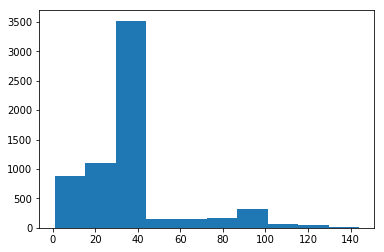

In [31]:
# Distribution of drug-combs
import matplotlib.pyplot as plt
arr = [len(obs[obs['combination_idx'] == x]) for x in set(obs['combination_idx'])]
plt.hist(arr)

In [32]:
# reducing size for faster computation
obs = obs[:30000]
len(set(obs['combination_idx']))

5636

In [61]:
#testing it on one single combination id

randIdx = [5,300,100]
weighted_corr=[]
weights=[]

for i in randIdx:

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))
df = pd.DataFrame({"corr":weighted_corr,"weights":weights}).dropna()
sum(df["corr"])/sum(df["weights"])

corr = np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])
print(f"Correlation between prediction and observation is {corr[0,1]}")

obs.loc[obs['combination_idx'].isin([5,100,300])]

Correlation between prediction and observation is -0.9981450650512003


,combination_idx,y_test,pred
222756,300,-0.88,-0.020
477247,300,3.33,8.370
536729,300,0.40,2.045
754753,5,3.31,-0.070
377069,5,4.82,-2.950
102593,300,-1.25,-0.020
378660,5,0.34,-0.385
323968,100,0.88,1.040
600481,300,-1.75,-0.350
323971,100,3.40,-1.210


In [ ]:
weighted_corr=[]
weights=[]
for i in set(obs['combination_idx']):

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))
df = pd.DataFrame({"corr":weighted_corr,"weights":weights}).dropna()
sum(df["corr"])/sum(df["weights"])

#### second training cycle: Forest

In [42]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

with open('intermediate-pickles/Y.pkl', 'rb') as inp:
    Y = pickle.load(inp)
with open('intermediate-pickles/X.pkl', 'rb') as inp:
    X = pickle.load(inp)

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

In [43]:
regressor = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100, verbose=True)
regressor.fit(X_train,Y_train)

predForestTrain=regressor.predict(X_train)
predForest=regressor.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 19.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [44]:
with open('intermediate-pickles/forest-100-Predictions.pkl', 'wb') as outp:
    pickle.dump(predForest, outp)
with open('intermediate-pickles/forest-100-TRAIN-Predictions.pkl', 'wb') as outp:
    pickle.dump(predForestTrain, outp)

#### scoring RF

In [46]:
with open('./intermediate-pickles/tree-Predictions-y-test.pkl', 'rb') as inp:
    obs = pickle.load(inp)
with open('./intermediate-pickles/tree-Predictions.pkl', 'rb') as inp:
    predTree = pickle.load(inp)
with open('./intermediate-pickles/forest-100-Predictions.pkl', 'rb') as inp:
    predForest = pickle.load(inp)
with open('./intermediate-pickles/forest-100-TRAIN-Predictions.pkl', 'rb') as inp:
    predForestTrain = pickle.load(inp)

In [ ]:
obs["pred"] = predTree
obs.head(2)

In [ ]:
%%capture --no-display
#tree

weighted_corr=[]
weights=[]
for i in set(obs['combination_idx']):

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))

df = pd.DataFrame({"corr":weighted_corr,"weights":weights}).dropna()
sum(df["corr"])/sum(df["weights"])

In [47]:
# forest
obs = pd.DataFrame({"combination_idx":x_test.iloc[:,0],"y_test":y_test})
obs["pred"] = predForest
obs.head(2)

,combination_idx,y_test,pred
574100,244500,-9.88,-0.108452
409272,291440,0.14,2.543879


In [16]:
%%capture --no-display
# forest test

weighted_corr=[]
weights=[]
for i in set(obs['combination_idx']):

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))

df = pd.DataFrame({"corr":weighted_corr,"weights":weights}).dropna()
sum(df["corr"])/sum(df["weights"])

0.0005667483520001927

Make the right df for forest train and see if there is a difference <br>
Then use other scoring metrics than this one to see whether it is really so bad

In [50]:
#forest train
obs = pd.DataFrame({"combination_idx":X_train.iloc[:,0],"y_train":Y_train})
obs["pred"] = predForestTrain
obs.head(2)

,combination_idx,y_train,pred
520672,66831,-0.31,-1.304147
178974,148088,-1.35,1.096855


In [20]:
%%capture --no-display
# forest train

weighted_corr=[]
weights=[]
for i in set(obs['combination_idx']):

    n = len(obs.loc[obs['combination_idx'] == i])
    
    if (np.var(obs["y_train"][obs['combination_idx'] == i]) == 0 and n > 1):
        weighted_corr.append(0)
        weights.append(np.sqrt(n-1))
    elif (n > 1):
        weighted_corr.append(np.sqrt(n-1) * np.corrcoef(obs.loc[obs['combination_idx'] == i]["y_train"], obs.loc[obs['combination_idx'] == i]["pred"])[0,1])
        weights.append(np.sqrt(n-1))

df = pd.DataFrame({"corr":weighted_corr,"weights":weights}).dropna()
sum(df["corr"])/sum(df["weights"])

0.0006324583444735

#### training dummy classifier

In [6]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

with open('intermediate-pickles/Y.pkl', 'rb') as inp:
    Y = pickle.load(inp)
with open('intermediate-pickles/X.pkl', 'rb') as inp:
    X = pickle.load(inp)

X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)

In [21]:
from sklearn.dummy import DummyRegressor
dummyRegressor = DummyRegressor()
dummyRegressor.fit(X_train,Y_train)

pred=dummyRegressor.predict(x_test)

In [22]:
obs = pd.DataFrame({"combination_idx":x_test.iloc[:,0],"y_test":y_test,"pred":pred})
obs.head(2)

,combination_idx,y_test,pred
224884,47245,-3.78,0.637093
637875,190791,-0.71,0.637093


In [32]:
%%capture --no-display
# very long computation
# input: obs is a Dataframe with 3 Columns: 1. A combination idx for the 2 drugs, y_test, pred
def primaryMetric2(obs):
    import numpy as np
    import pandas as pd
    weighted_corr = []
    weights = []
    for i in set(obs['combination_idx']):

        n = len(obs.loc[obs['combination_idx'] == i])

        if (np.var(obs["y_test"][obs['combination_idx'] == i]) == 0 and n > 1):
            weighted_corr.append(0)
            weights.append(np.sqrt(n-1))
        elif (n > 1):
            weighted_corr.append(np.sqrt(n-1) * np.corrcoef(
                obs.loc[obs['combination_idx'] == i]["y_test"], obs.loc[obs['combination_idx'] == i]["pred"])[0, 1])
            weights.append(np.sqrt(n-1))
    df = pd.DataFrame({"corr": weighted_corr, "weights": weights}).dropna()
    return(sum(df["corr"])/sum(df["weights"]))


from scoring import primaryMetric
primaryMetric2(obs)

-3.457277076837825e-19

#### Alternative metrics

In [52]:
# forest train
np.mean(np.abs(obs["y_train"]-obs["pred"]))

4.439317484664892

In [49]:
# forest test
np.mean(np.abs(obs["y_test"]-obs["pred"]))

4.432073412723623

In [40]:
#dummy
np.mean(np.abs(obs["y_test"]-obs["pred"]))

4.736881073728012

#### See RFs main features

In [70]:
feats = pd.DataFrame([np.array(x_test.columns),regressor.feature_importances_]).transpose()
feats.sort_values(by=1,ascending=False)
# MR mutagenic potential
# SMR same

,0,1
45,D1 MolMR,0.317932
115,D2 MolMR,0.225306
103,D2 Chi1,0.101123
59,D1 SMR_VSA1,0.089432
129,D2 SMR_VSA1,0.049981
...,...,...
58,D1 PEOE_VSA3,0.0
57,D1 PEOE_VSA2,0.0
55,D1 LabuteASA,0.0
54,D1 TPSA,0.0


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.41654475e-03, 4.18614337e-04, 1.83565491e-03, 1.01829437e-04,
       7.66101705e-04, 3.86505775e-03, 7.92203159e-05, 2.19228062e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.11777406e-03,
       0.00000000e+00, 0.00000000e+00, 8.26200172e-03, 0.00000000e+00,
       1.72724591e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.03684168e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.39764403e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.93986899e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.85309609e-05, 1.50880277e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.27743795e-04, 0.00000000e+00,
       7.21344913e-03, 3.17932268e-01, 8.69960830e-03, 3.44165354e-04,
       4.59820728e-04, 2.08246661e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.17204280e-04, 0.00000000e+00, 0.00000000e+00,
      

#### Advancing DataFrame

In [63]:
with open('intermediate-pickles/X.pkl', 'rb') as inp:
    X = pickle.load(inp)
X.head()

,index,D1 Eccentricity,D1 InertialShapeFactor,D1 NPR1,D1 NPR2,D1 PMI1,D1 PMI2,D1 PMI3,D1 RadiusOfGyration,D1 SpherocityIndex,...,D2 VSA_EState2,D2 VSA_EState3,age,cat_Cancer cell line,cat_Embryonic stem cell,cat_Hybridoma,cat_Transformed cell line,gender_Female,gender_Male,gender_Sex unspecified
0,300073,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,300073,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,300073,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,300073,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,...,19.238682,3.448989,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,190819,0.956402,0.004792,0.292055,0.707945,147.739172,358.121584,505.860756,1.97203,1.259740e-12,...,31.601287,14.099736,43.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
import pandas as pd
df = pd.read_csv("../drugCombDBdata/drugcombs_response.csv")
df.shape

(6103237, 11)